In [1]:
from lib import cnn_tester
import sys
sys.path.insert(0, '../src')
from lib import datasets

from os.path import join as opj
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=RuntimeWarning)

# Hyperparameters validation - Computation of performance

In [2]:
# Directories
data_dir = '../data/preprocessed/HCP_dataset'
out_dir = '../data/derived/HCP_dataset'

In [3]:
# Specific setup
preprocess_type = 'resampled_masked_normalized'

# Training setup 
train_subset ='hcp_global_dataset'
lr = '1e-04'
model_to_test = ['model_cnn_4layers', 'model_cnn_5layers']
init_to_test = ['retrain_no', 'retrain_all']
batch_to_test = [32, 64]

# Validation setup
valid_id_file = opj(data_dir, f'valid_hcp_global_dataset.txt')
label_file = opj(data_dir, f'hcp_global_dataset_labels.csv')
label_col = 'contrast'
label_df = pd.read_csv(label_file)
label_list = sorted(np.unique(label_df[label_col]))

valid_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), valid_id_file, label_file, label_col, 
                        label_list)

In [4]:
# Supplementary Figure S2 - Performance on classification of global HCP dataset of models 
# with different hyperparameters. 

accuracies = []
f1_list = []
model_list = []
arch_list = []
epochs_list = []
batch_list = []
prec_list = []
rec_list = []

if not os.path.exists('../figures/validation_model_hcp.csv'):
    print('Calculating validation performance...')
    for model in model_to_test:
        for init in init_to_test:
            if init == 'retrain_no':
                epochs_to_test = [200, 500]
            else:
                epochs_to_test = [200]

            for epochs in epochs_to_test:
                for batch in batch_to_test:
                    
                    model_list.append(init)
                    arch_list.append(model)
                    batch_list.append(batch)
                    epochs_list.append(epochs)
                    
                    
                    # Model to test
                    parameter_file = opj(out_dir, f"{train_subset}_maps_classification_contrast_{model}_" + \
                            f"{init}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}", 
                                         "model_final.pt")

                    acc, f1, prec, rec, acc_class = cnn_tester.tester(valid_set, parameter_file) # Compute results

                    accuracies.append(acc)
                    f1_list.append(f1)
                    prec_list.append(prec)
                    rec_list.append(rec)
                    
    # Creation of dataframe with results
    init_list = ['Default algorithm' if i == 'retrain_no' else 'Pre-trained CAE' for i in model_list]

    arch_list = ['5 layers' if i == 'model_cnn_5layers' else '4 layers' for i in arch_list]

    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Initialization']=init_list
    df['Batch']=batch_list
    df['Epochs']=epochs_list
    df['Architecture']=arch_list
    df['Precision']=prec_list
    df['Recall']=rec_list

    df.to_csv('../figures/validation_model_hcp.csv') 
    
else: 
    print('Validation metrics already computed.')

Validation metrics already computed.


# Hyperparameter validation - Exploration of results

### Table 3 - Hyperparameters chosen for each dataset and corresponding performance of the classifier on the validation set of the dataset 

Here, we computed the results of Table 3 for HCP dataset.

In [5]:
df = pd.read_csv('../figures/validation_model_hcp.csv') 
df[df['Initialization']=='Default algorithm'].nlargest(1, ['Accuracy', 'F1'])

,Unnamed: 0,Unnamed: 0.1,Accuracy,F1,Initialization,Batch,Epochs,Architecture,Precision,Recall
3,3,3,0.910815,0.911404,Default algorithm,64,500,4 layers,0.912956,0.911757


In [6]:
df[df['Initialization']=='Pre-trained CAE'].nlargest(1, ['Accuracy', 'F1'])

,Unnamed: 0,Unnamed: 0.1,Accuracy,F1,Initialization,Batch,Epochs,Architecture,Precision,Recall
11,13,13,0.915345,0.915654,Pre-trained CAE,64,200,5 layers,0.916488,0.915588


# Test models with cross-validation

## Contrast classification - Table 4 and Figure 4

In [7]:
# Table 4 - Classification performance on HCP datasets of models initialized with default algorithm vs 
# with the weights of a pre-trained CAE. 
# PART 1 - CLASSIFICATION OF CONTRASTS 
if not os.path.exists('../figures/test_hcp_contrast_sample_size.csv'):
    print('Calculating performance...')
    accuracies = []
    f1_list = []
    prec_list = []
    rec_list = []
    prec_list = []
    model_list = []
    n_list=[]

    lr = '1e-04'

    for n in ['50', '100', '200', '500', 'global']: # Iterates on all sample sizes 
        # Name of the training set used 
        train_subset ='hcp_global_dataset_' + n
        test_subset = 'hcp_global_dataset_' + n

        if n =='global':
            train_subset = 'hcp_global_dataset'
            test_subset ='hcp_global_dataset'

        # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
        train_id_file = opj(data_dir, f'train_hcp_global_dataset.txt')
        test_id_file = opj(data_dir, f'test_hcp_global_dataset.txt')
        label_file = opj(data_dir, f'hcp_global_dataset_labels.csv')
        label_col = 'contrast'
        label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                     f'hcp_global_dataset_labels.csv'))

        label_list = sorted(np.unique(label_filelist['contrast']))

        train_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), train_id_file, label_file, label_col,
                                           label_list)
        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                          label_list)

        # Compute results performance for DEFAULT ALGORITHM
        model = 'model_cnn_4layers_retrain_no'
        epochs = 500
        batch=64
        model_list.append('Default algorithm')
        parameter_file = opj(out_dir, 
    f'{train_subset}_maps_classification_contrast_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_best.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        n_list.append(n)
        prec_list.append(prec)
        rec_list.append(rec)

        # Compute results performance for PRE-TRAINED CAE 
        model = 'model_cnn_5layers_retrain_all'
        epochs = 200
        batch=64
        model_list.append('Pre-trained CAE')

        parameter_file = opj(out_dir, 
            f'{train_subset}_maps_classification_{label_col}_' + \
                             f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_best.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        n_list.append(n)
        prec_list.append(prec)
        rec_list.append(rec)
            
    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Precision']=prec_list
    df['Recall']= rec_list
    df['Subject']=n_list

    df.to_csv('../figures/test_hcp_contrast_sample_size.csv') # Global dataframe 
else:
    print('Performance already computed.')

Performance already computed.


In [8]:
df = pd.read_csv('../figures/test_hcp_contrast_sample_size.csv')

In [9]:
# Mean values and standard errors
for sub in ['50', '100', '200', '500', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub]) * 100, 1)))
    
    print('Pre-trained CAE')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub]) * 100, 1)))

Sample 50
Default algorithm
78.6
Pre-trained CAE
83.5
Sample 100
Default algorithm
84.3
Pre-trained CAE
87.4
Sample 200
Default algorithm
88.5
Pre-trained CAE
90.1
Sample 500
Default algorithm
91.4
Pre-trained CAE
92.2
Sample global
Default algorithm
92.5
Pre-trained CAE
92.3


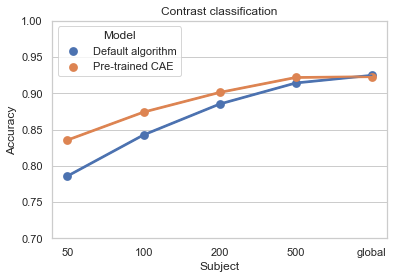

In [10]:
# Plot figure 
sns.set_theme(style="whitegrid")

ax = sns.pointplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci=None)

ax = sns.lineplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci='sd', legend=False)

ax.set_title("Contrast classification")
ax.set_ylim(0.70, 1)

ax.figure.savefig('../figures/fig4.png')

## Task classification - Table 4 and Figure 5

In [11]:
# Table 4 - Classification performance on HCP datasets of models initialized with default algorithm vs 
# with the weights of a pre-trained CAE. 
# PART 1 - CLASSIFICATION OF CONTRASTS 
if not os.path.exists('../figures/test_hcp_task_sample_size.csv'):
    print('Calculating performance...')
    accuracies = []
    f1_list = []
    prec_list = []
    rec_list = []
    prec_list = []
    model_list = []
    n_list=[]

    lr = '1e-04'

    for n in ['50', '100', '200', '500', 'global']: # Iterates on all sample sizes 
        # Name of the training set used 
        train_subset ='hcp_global_dataset_' + n
        test_subset = 'hcp_global_dataset_' + n

        if n =='global':
            train_subset = 'hcp_global_dataset'
            test_subset ='hcp_global_dataset'

        # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
        train_id_file = opj(data_dir, f'train_hcp_global_dataset.txt')
        test_id_file = opj(data_dir, f'test_hcp_global_dataset.txt')
        label_file = opj(data_dir, f'hcp_global_dataset_labels.csv')
        label_col = 'task'
        label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                     f'hcp_global_dataset_labels.csv'))

        label_list = sorted(np.unique(label_filelist[label_col]))

        train_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), train_id_file, label_file, label_col,
                                           label_list)
        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                          label_list)

        # Compute results performance for DEFAULT ALGORITHM
        model = 'model_cnn_4layers_retrain_no'
        epochs = 500
        batch=64
        model_list.append('Default algorithm')
        parameter_file = opj(out_dir, 
    f'{train_subset}_maps_classification_{label_col}_{model}' + \
                             f'_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_best.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        n_list.append(n)
        prec_list.append(prec)
        rec_list.append(rec)

        # Compute results performance for PRE-TRAINED CAE 
        model = 'model_cnn_5layers_retrain_all'
        epochs = 200
        batch=64
        model_list.append('Pre-trained CAE')

        parameter_file = opj(out_dir, 
            f'{train_subset}_maps_classification_{label_col}_' + \
                             f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_best.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        n_list.append(n)
        prec_list.append(prec)
        rec_list.append(rec)

    df = pd.DataFrame()

    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Subject']=n_list
    df['Precision']=prec_list
    df['Recall']=rec_list

    df.to_csv('../figures/test_hcp_task_sample_size.csv')
else:
    print('Performance already computed.')

Performance already computed.


In [12]:
df = pd.read_csv('../figures/test_hcp_task_sample_size.csv')

In [13]:
# Mean values and standard errors
for sub in ['50', '100', '200', '500', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub]) * 100, 1)))
    
    print('Pre-trained CAE')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub]) * 100, 1)))

Sample 50
Default algorithm
96.2
Pre-trained CAE
97.6
Sample 100
Default algorithm
98.3
Pre-trained CAE
98.6
Sample 200
Default algorithm
99.1
Pre-trained CAE
98.9
Sample 500
Default algorithm
99.6
Pre-trained CAE
99.6
Sample global
Default algorithm
99.7
Pre-trained CAE
99.7


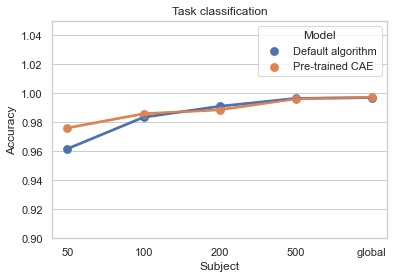

In [14]:
# Plot figure 
sns.set_theme(style="whitegrid")

ax = sns.pointplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci=None)

ax = sns.lineplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci='sd', legend=False)

ax.set_title("Task classification")
ax.set_ylim(0.90, 1.05)

ax.figure.savefig('../figures/fig5.png')

## One contrast task classification - Table 4 and Figure 6

In [15]:
if not os.path.exists('../figures/test_hcp_one_contrast_task_sample_size.csv'):
    print('Calculating performance...')
    accuracies = []
    f1_list = []
    prec_list = []
    rec_list = []
    model_list = []
    n_list=[]

    lr = '1e-04'

    for n in ['50','100', '200', '500', 'global']:
        train_subset ='small_hcp_global_dataset_' + n
        test_subset = 'small_hcp_global_dataset_' + n

        if n =='global':
            train_subset = 'small_hcp_global_dataset'
            test_subset ='small_hcp_global_dataset'

        train_id_file = opj(data_dir, f'train_small_hcp_global_dataset.txt')
        test_id_file = opj(data_dir, f'test_small_hcp_global_dataset.txt')
        label_file = opj(data_dir, f'small_hcp_global_dataset_labels.csv')
        label_col = 'task'
        label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                     f'{test_subset}_labels.csv'))
        label_list = sorted(np.unique(label_filelist[label_col]))

        train_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), train_id_file, label_file, label_col,
                                           label_list)
        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                          label_list)

        model = 'model_cnn_4layers_retrain_no'
        epochs = 500
        batch=64
        model_list.append('Default algorithm')
        parameter_file = opj(out_dir, f'{train_subset}_maps_classification_{label_col}' + \
                             f'_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_final.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
        n_list.append(n)

        model = 'model_cnn_5layers_retrain_all'
        epochs = 200
        batch=64
        model_list.append('Pre-trained CAE')
        parameter_file = opj(out_dir, 
                    f'{train_subset}_maps_classification_{label_col}' + \
                    f'_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_final.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
        n_list.append(n)

    df = pd.DataFrame()

    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Subject']=n_list
    df['Precision']=prec_list
    df['Recall']=rec_list

    df.to_csv('../figures/test_hcp_one_contrast_task_sample_size.csv')
    
else:
    print('Performance already computed.')

Performance already computed.


In [16]:
df = pd.read_csv('../figures/test_hcp_one_contrast_task_sample_size.csv')

In [17]:
# Mean values and standard errors
for sub in ['50', '100', '200', '500', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub]) * 100, 1)))
    
    print('Pre-trained CAE')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub]) * 100, 1)))

Sample 50
Default algorithm
97.2
Pre-trained CAE
98.1
Sample 100
Default algorithm
98.6
Pre-trained CAE
98.7
Sample 200
Default algorithm
99.1
Pre-trained CAE
99.1
Sample 500
Default algorithm
99.3
Pre-trained CAE
99.3
Sample global
Default algorithm
99.1
Pre-trained CAE
99.3


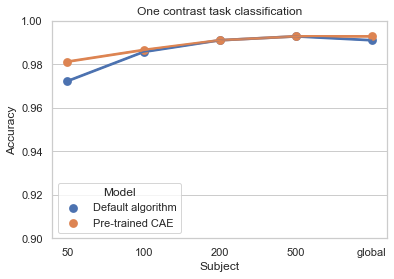

In [18]:
# Plot figure
sns.set_theme(style="whitegrid")

ax = sns.pointplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci=None)

ax = sns.lineplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci='sd', legend=False)

ax.set_title("One contrast task classification")
ax.set_ylim(0.90, 1.00)

ax.figure.savefig('../figures/fig6.png')